## Take Home Exercise

### 0. Loading data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%matplotlib inline

import datetime
import seaborn
import copy
import sys
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing 
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

In [33]:
data = pd.read_csv('./Data Scientist.docx')
data.head()

,member_id,loan_amnt,int_rate,issue_d,loan_status,fico_range_low,fico_range_high,annual_inc,last_pymnt_d
0,35784929,18000,9.17%,Oct 2014,Fully Paid,700,704,150000,Oct 2015
1,35914827,14000,11.67%,Oct 2014,Current,670,674,135000,Oct 2015
2,35985086,8400,9.17%,Oct 2014,Current,665,669,75000,Oct 2015
3,35945193,10000,7.69%,Oct 2014,Current,730,734,94000,Oct 2015
4,35754571,2000,12.99%,Oct 2014,Current,680,684,150000,Oct 2015


In [34]:
print 'Original data size:', data.shape
print 'New data size without last_pymnt_d = NA:', data.dropna().shape

data = data[~data['last_pymnt_d'].isnull()]
data['last_pymnt_d'] = data['last_pymnt_d'].apply(lambda x: datetime.datetime.strptime(x, '%b %Y'))
data['issue_d'] = data['issue_d'].apply(lambda x: datetime.datetime.strptime(x, '%b %Y'))
data['int_rate'] = data['int_rate'].apply(lambda x:float(x.strip('%')) / 100.0)

Original data size: (239046, 9)
New data size without last_pymnt_d = NA: (237709, 9)


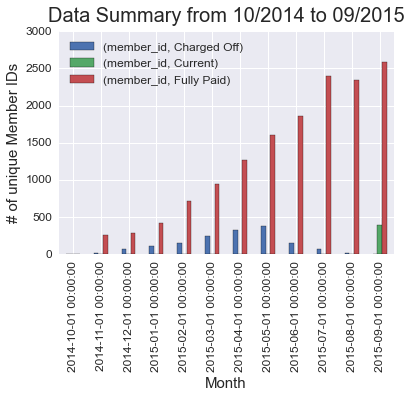

In [35]:
ax = data[data['last_pymnt_d']<datetime.datetime(2015,10,1)].\
groupby(['last_pymnt_d', 'loan_status']).\
agg({'member_id':lambda x:x.nunique()}).\
unstack('loan_status').\
plot(kind='bar')

plt.title('Data Summary from 10/2014 to 09/2015', fontsize=20, y=1.02)
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('# of unique Member IDs',fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.show()

### 1. What is the relationship between FICO score and interest rate?
 
They are negatively correlated, or say, the higher FICO score is associated with the lower interest rate. Mathematically the correlation coefficient between interest rate and FICO score is -0.43.

In [36]:
np.corrcoef(data['int_rate'], data['fico_range_high'])

array([[ 1.       , -0.4250423],
       [-0.4250423,  1.       ]])

In [37]:
np.corrcoef(data['int_rate'], data['fico_range_low'])

array([[ 1.        , -0.42504557],
       [-0.42504557,  1.        ]])

* Since most of the "fico_range_high" and "fico_range_low" are different by 4 points, I used "fico_range_high" to represent each borrower's FICO score.

In [38]:
data['fico_diff'] = data['fico_range_high'] - data['fico_range_low']
data[~data['last_pymnt_d'].isnull()].groupby(['loan_status']).agg({'fico_diff':'mean', 'member_id':'count'})

,fico_diff,member_id
loan_status,,
Charged Off,4.000000,1591
Current,4.000127,219634
Fully Paid,4.000182,16484


### 2. What is the relationship between loan size and interest rate?

The correlation coefficient between loan_amnt and interest rate is **-0.09**, which means loan_amnt and int_rate are weakly negatively correlated. However, if using loan_amnt / annual_inc indicate the capability of paying the loans, they are weakly positively correlated **(with coefficient = 0.14)**.

In [39]:
np.corrcoef(data['loan_amnt'], data['int_rate'])

array([[ 1.        , -0.09460382],
       [-0.09460382,  1.        ]])

In [40]:
np.corrcoef(np.log(data['loan_amnt']), data['int_rate'])

array([[ 1.        , -0.13932875],
       [-0.13932875,  1.        ]])

In [41]:
np.corrcoef(data['loan_amnt'] / data['annual_inc'], data['int_rate'])

array([[ 1.       ,  0.1430842],
       [ 0.1430842,  1.       ]])

### 3. Does it seem like the size of a loan and/or the borrower’s FICO score are related to whether or not the loan ends up being charged off? How might this relate to your answer to the previous question?

Leveraging FICO scores and loan amount as features, I have trained a logistic regression model to learn "Charged Off" or "Fully Paid" as target. With normalized features, the coefficients of fitted logistic model can be considered as the multiple correlation coefficients. It is noticeable that the loan size is weakly correlated with the loan status "Charged Off" or not, while FICO score is strongly correlated. 

As far as we know, FICO scores are correlated with Charged off/Fully paid, and interest rates are negatively correlated with FICO scores. We might infer that the interest rates are related to the loans ends up being charged off or not. This has been confirmed by fitting another logistic regression model including **"interest rate"** as a third feature). Loan amount are weakly correlatd with Charged off status, and thus weakly related to interest rate. This is consitent with the conclusion from question 2.

In [42]:
tmp = data[data['loan_status']!='Current'].copy()
tmp.ix[tmp['loan_status']=='Current', 'target']=-1
tmp.ix[tmp['loan_status']=='Charged Off', 'target']=0
tmp.ix[tmp['loan_status']=='Fully Paid', 'target']=1

In [43]:
logistic = LogisticRegression(tol=1e-6)

scaler = preprocessing.StandardScaler().fit(tmp[['loan_amnt', 'fico_range_high']])
logistic.fit(scaler.transform(tmp[['loan_amnt', 'fico_range_high']]), tmp['target'])

print 'coef of loan_amnt = {}'.format(logistic.coef_[0][0])
print 'coef of fico_range_high = {}'.format(logistic.coef_[0][1])

coef of loan_amnt = -0.10628738971
coef of fico_range_high = 0.512708897691


In [44]:
logistic = LogisticRegression(tol=1e-6)

scaler = preprocessing.StandardScaler().fit(tmp[['loan_amnt', 'fico_range_high', 'int_rate']])
logistic.fit(scaler.transform(tmp[['loan_amnt', 'fico_range_high', 'int_rate']]), tmp['target'])

print 'coef of loan_amnt = {}'.format(logistic.coef_[0][0])
print 'coef of fico_range_high = {}'.format(logistic.coef_[0][1])
print 'coef of int_rate = {}'.format(logistic.coef_[0][2])

coef of loan_amnt = -0.0805935496959
coef of fico_range_high = 0.273140630435
coef of int_rate = -0.62217949019


### 4. What percentage of loans have been charged off as of October 2015?

Considering all loans (~240K borrowers) from October 2014 to October 2015, there are ~0.6% charged off in loan numbers and loan size respectively.

In [45]:
print 'Total number of the loans:', data.shape[0]
print 'Total amount of the loans:', data['loan_amnt'].sum()

Total number of the loans: 237709
Total amount of the loans: 3033564675


In [46]:
data.groupby(['loan_status']).agg({'member_id':'count'}).div(data.shape[0])

,member_id
loan_status,
Charged Off,0.006693
Current,0.923962
Fully Paid,0.069345


In [47]:
data.groupby(['loan_status']).agg({'loan_amnt':'sum'}).div(data['loan_amnt'].sum())

,loan_amnt
loan_status,
Charged Off,0.006267
Current,0.930842
Fully Paid,0.062891


### 5. Some of the loans which are marked “Current” in October 2015 will end up being charged off before they are paid in full. Using the fact that all of these loans are 3 years in length, estimate the probability that a randomly chosen loan would eventually become charged off, possibly after October 2015. Be sure to explain any assumptions you make.

A random forest classifier has been trained to learn the patterns of the borrrowers who either have "Fully Paid" or "Charged Off". There are two training scenarios: 

1. Randomly split the data as 70% for training and 30% for testing. The random forest classifier can achieve **AUC = 76%**. 

2. Split the data by the specific month, 2015-08. I used the the loans before 2015-08 for training, and validate the performance on 2015-09 and 2015-10, **AUC = 74%**.

The loans marked as "Current" are only found in 2015-09 and 2015-10. I have re-assigned the new month, for example "2016-01", to the borrowers, and then apply the random forest classifier to estimate the probability to end up being 'Charged Off'.

One more thing worthy of mention is that I created a new feature "time_to_fully_paid" to reflect how much more time for the current loan to be paid off, which is calculated as:

**time_to_fully_paid = 3 years - time_since_issue_d**

Also **"loan_ratio"**, the ratio of "loan_amnt" and "annual_inc", is used in the model to indicate the loan paying capability with repsect to the annual income levels.

You can find the predicted probability histogram of 'Current' loans being charged off in January 2016 below.

In [48]:
data['month_since_launch'] = (data['last_pymnt_d'] - data['issue_d']).apply(int) / (86400 * 1e9)
data['time_to_fully_paid'] = 365 * 3.0 - data['month_since_launch'] 
data['loan_ratio'] = data['loan_amnt'] / data['annual_inc']

In [49]:
Features = ['loan_amnt', 'int_rate',
           'fico_range_high', 'annual_inc',
           'time_to_fully_paid', 'loan_ratio']

In [50]:
training_data = data[data['loan_status']!='Current'].copy()
training_data.ix[training_data['loan_status']=='Current', 'target']=-1
training_data.ix[training_data['loan_status']=='Charged Off', 'target']=1
training_data.ix[training_data['loan_status']=='Fully Paid', 'target']=0

**Model training scenario 1: Random Split**

In [51]:
train_x,  test_x, train_y, test_y = train_test_split(training_data[Features], training_data['target'], test_size=0.3)
train_x.shape, test_x.shape

((12652, 6), (5423, 6))

In [52]:
rf = RandomForestClassifier(n_estimators=400, n_jobs=4, min_samples_split=100)
rf.fit(train_x, train_y)

prediction =rf.predict_proba(test_x)

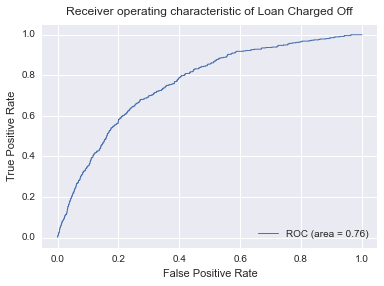

In [53]:
from sklearn.metrics import roc_curve, auc

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)


fpr, tpr, thres = roc_curve(test_y, prediction[:,1])
mean_tpr += np.interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Loan Charged Off', y=1.02)
plt.legend(loc="lower right")
plt.show()

**Model training scenario 2: Split on 2015-08**

In [54]:
from sklearn.cross_validation import train_test_split

splitDate = datetime.datetime(2015,8,1)
train_x = training_data[training_data['last_pymnt_d']<splitDate][Features]
test_x = training_data[training_data['last_pymnt_d']>=splitDate][Features]

train_y = training_data[training_data['last_pymnt_d']<splitDate]['target']
test_y = training_data[training_data['last_pymnt_d']>=splitDate]['target']

train_x.shape, test_x.shape

((11312, 6), (6763, 6))

In [55]:
rf = RandomForestClassifier(n_estimators=400, n_jobs=4, min_samples_split=100)
rf.fit(train_x, train_y)

prediction =rf.predict_proba(test_x)

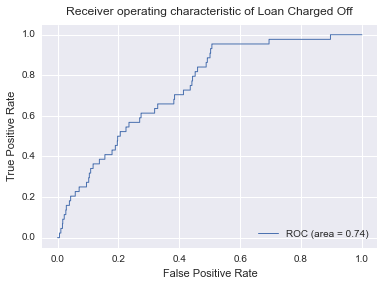

In [56]:
from sklearn.metrics import roc_curve, auc

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 500)

fpr, tpr, thres = roc_curve(test_y, prediction[:,1])
mean_tpr += np.interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Loan Charged Off', y=1.02)
plt.legend(loc="lower right")
plt.show()

#### Reset 'Current' loans to the new month, 01/2016:

In [57]:
validation_data = data[data['loan_status']=='Current'].copy()
validation_data['month_since_launch'] = (datetime.datetime(2016,1,1) - validation_data['issue_d']).\
apply(int) / (86400 * 1e9)
validation_data['time_to_fully_paid'] = 365 * 3.0 - validation_data['month_since_launch'] 

In [58]:
validation_data.groupby(['last_pymnt_d', 'loan_status']).agg({'member_id':lambda x:x.nunique(0)})

,,member_id
last_pymnt_d,loan_status,
2015-09-01,Current,391
2015-10-01,Current,219243


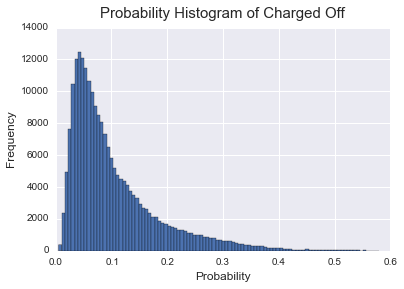

In [59]:
hist = plt.hist(rf.predict_proba(validation_data[Features])[:,1], bins=100)
plt.title('Probability Histogram of Charged Off', y=1.02, fontsize=15)
plt.xlabel('Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)